In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
from helper_fns import yaml_load

nlpopts = { "print_time":False,      # Prints the time for evaluating objective, calculating gradients, etc
            "ipopt.print_level":0,   # Integer from 0 to 5, 5 printing the most information
            "ipopt.tol":1.0e-5,
            "ipopt.acceptable_constr_viol_tol":2.0e-04,
            "ipopt.warm_start_init_point":"yes",
            "ipopt.warm_start_bound_frac":1.0e-09,
            "ipopt.warm_start_bound_push":1.0e-09,
          }

In [2]:
from robot import Robot
from contact import Contact
from impedance_controller import ImpedanceController
from decision_vars import DecisionVarSet
par = {'pos': [0, 0, 0.0],
       'stiff': [0, 0, 3e4],
        'rest':[0, 0, 0.7]}
attrs = yaml_load('config/attrs.yaml')
attrs = {k:attrs[k] for k in ['lb', 'ub']}
c = Contact('c/', par, [], attrs=attrs)
imp = ImpedanceController(input_vars = ['imp_rest'],
                          attrs = attrs)
rob = Robot('config/franka.urdf', subsys = [c], ctrl = imp, attrs = attrs, visc_fric = 100)

Building robot model from config/franka.urdf with TCP fr3_link8
  with subsys ['c/']
  with control imp_ctrl


In [4]:
from mpc import MPC
from helper_fns import mult_shoot_rollout
from robot import *

mpc = MPC(robots={'free':rob}, mpc_params={'H':7, 'dt':0.05}, nlpopts =nlpopts)
params = {'q': ca.DM.zeros(7),
          'dq': ca.DM.zeros(7),
          'belief_free':1.0, 
          'imp_stiff':400*ca.DM.ones(3),}
res = mpc.solve(params)
res['imp_stiff'] = params['imp_stiff']
traj = rob.get_ext_state(res)


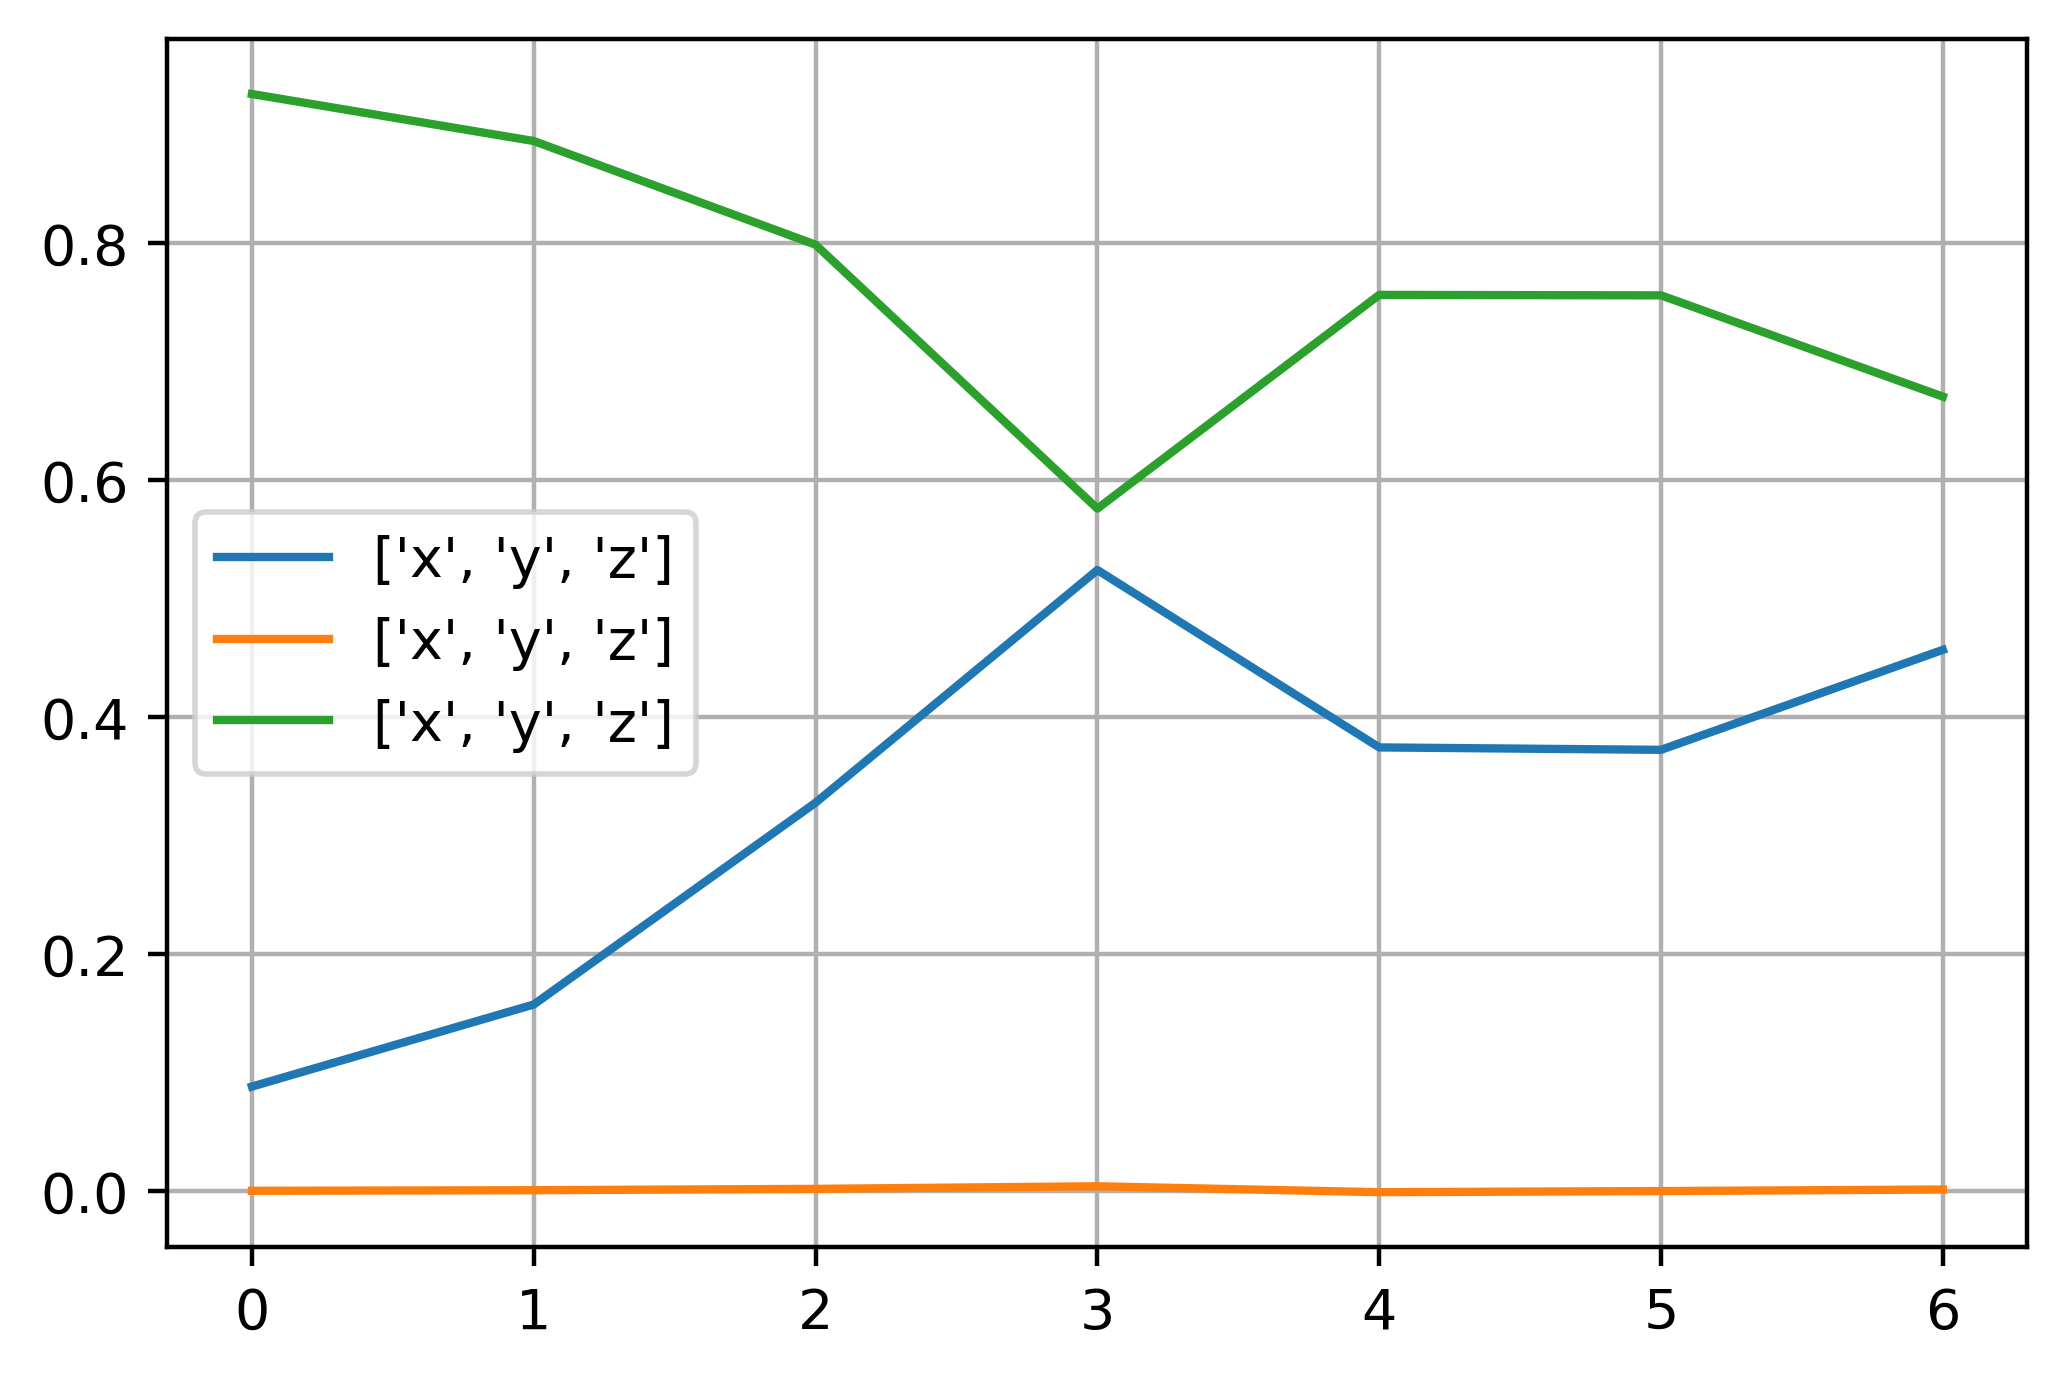

In [6]:
import matplotlib.pyplot as plt
import numpy as np

p = np.squeeze(np.array(traj['p'].T))
plt.plot(p, label=['x', 'y', 'z'])
plt.legend()

In [8]:
import time
N = 100
times = []

for _ in range(N):
    params['q'] += 0.05*np.random.randn(7) # perturb initial state
    tic = time.perf_counter()
    sol = mpc.solve(params)
    times.append(time.perf_counter()-tic)
    
print(f'Cold start time:  {times[0]} sec')
print(f'Cold start rate:  {1/times[0]} Hz')
print(f'Warm start rate: {1/np.mean(times[1:])} Hz')

Cold start time:  0.003563737031072378 sec
Cold start rate:  280.60431824260786 Hz
Warm start rate: 316.51678696470526 Hz


In [17]:
from robot import Robot
from contact import Contact
from impedance_controller import ImpedanceController
from decision_vars import DecisionVarSet
par = {'pos': [0, 0, 0.0],
       'stiff': [0, 0, 3e4],
        'rest':[0, 0, 0.7]}
attrs = yaml_load('config/attrs.yaml')
attrs = {k:attrs[k] for k in ['lb', 'ub']}
imp = ImpedanceController(input_vars = ['imp_rest'],
                          attrs = attrs)
rob = Robot('config/franka.urdf', subsys = [], ctrl = imp, attrs = attrs, visc_fric = 100)
rob.build_step(0.1)
rob.build_rollout(10, 20)

#%timeit rob.rollout_red(np.zeros(14), np.zeros(3))
#%timeit rob.rollout(np.zeros(14), np.zeros(3), np.zeros(3))

%timeit rob.rollout(np.zeros(14), np.zeros(3), np.ones(3))
# 110 us for 20 samples, + 1.7 ms to build, more efficient over 10 iterations
#%timeit rob.rollout_red_map(np.zeros((14,20)), np.zeros(3), 200*np.ones(3))
# 310 us for 20 samples
%timeit rob.rollout_map(np.zeros((14,20)), np.zeros(3), np.zeros(3))

Building robot model from config/franka.urdf with TCP fr3_link8
  with control imp_ctrl
14.4 µs ± 172 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
45.7 µs ± 224 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
